# Speech Command Recognition

## Import Libraries

In [1]:
import os
import sys
import glob
import shutil
import librosa
import warnings
import numpy as np
import pandas as pd
import os.path as osp
import tensorflow as tf

from tqdm import tqdm
from python_speech_features import mfcc, logfbank
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
PATH = osp.dirname(os.getcwd())

2023-03-06 13:19:06.167490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 13:19:06.277953: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-06 13:19:06.280750: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-06 13:19:06.280774: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Load Dataset

In [2]:
download_link = 'http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip'
dataset_name = 'mini_speech_commands'
dataset_path = osp.join(PATH, 'data', dataset_name)
if not osp.exists(dataset_path):
    tf.keras.utils.get_file('mini_speech_commands.zip',
                            origin=download_link,
                            extract=True,
                            cache_dir='../', 
                            cache_subdir=dataset_path)
    
# Remove all unwanted directories from downloads
extracted_dataset_path = osp.join(dataset_path, dataset_name)
path_list = [osp.join(dataset_path, file) for file in os.listdir(dataset_path)]
path_list.remove(extracted_dataset_path)
for path in path_list:
    if osp.isfile(path): os.remove(path)        
    if osp.isdir(path): shutil.rmtree(path)
        
print('Done!')    

182082353/182082353 [==============================] - 74s 0us/step
Done!


In [3]:
# Create a list of all the wav files
subdir_list = [sub_dir for sub_dir in os.listdir(extracted_dataset_path)]
if 'README.md' in subdir_list:
    subdir_list.remove('README.md')

files = []
files_count = []

for sub_dir in subdir_list:
    sub_files = [f for f in glob.glob(osp.join(extracted_dataset_path, sub_dir, '*.wav'), recursive=True)]
    files.extend(sub_files)
    files_count.append(len(sub_files))
    

df = pd.DataFrame(list(zip(subdir_list, files_count)),
              columns=['Keyword','File_Count'])

print(df)

print('Done!')    

  Keyword  File_Count
0    stop        1000
1      no        1000
2      up        1000
3   right        1000
4     yes        1000
5    down        1000
6      go        1000
7    left        1000
Done!


## Preprocessing Data

In [4]:
sample_rate = 16000
keyword_list = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
keyword_idxlist = list(range(0,len(keyword_list)))

df = pd.DataFrame(list(zip(keyword_list, keyword_idxlist)),
              columns=['Keyword','Idx'])

# Read audio and check clip duration
audio_data = []
min_length = sample_rate
max_length = 0

for fn in tqdm(files): 
    samples, sr = librosa.core.load(fn, sr=None, mono=True)
    sample_length = len(samples)
    label = osp.basename(osp.dirname(fn))
    label_id = keyword_list.index(label) 
    if sample_length > max_length:
        max_length = sample_length
    if sample_length < min_length:
        min_length = sample_length
        
    samples = np.append(samples, [label_id])
    audio_data.append(samples)    


# Equalize Clipduration
for data in tqdm(audio_data): 
    data_length = len(data[:-1])
    if data_length < max_length:
        required_length = max_length - data_length    
        audio_data[audio_data.index(data)] = np.hstack((data[:-1], np.zeros(required_length), data[-1])).astype(data.dtype)
    else:
        required_length = 0  

print('Done!')            

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:15<00:00, 503.04it/s]

Done!


## Feature Extraction

In [5]:
# Mfcc feature exractio for audio
x_data = []
y_data = []

for data in tqdm(audio_data):
    label = data[-1]
    data = data[:-1]
    feature_vec = mfcc(data, sample_rate, winlen=0.025, winstep=0.01)
    x_data.append([feature_vec])   
    y_data.append(int(label))
    
x_data = np.array(x_data)    
x_data = np.squeeze(x_data, axis=1)
y_data = np.array(y_data) 

print('Done!')    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:12<00:00, 110.62it/s]

Done!


## Train Val Test Split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.30)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.10)

print('Done!')    

Done!


## Compute class weights & One hot encoding

In [7]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
class_weights = dict(enumerate(class_weights))

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=len(keyword_list))
y_val = to_categorical(y_val, num_classes=len(keyword_list))

print('Done!')    

Done!


## Model Generation & Training 

In [8]:
#Generate Model

from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import LayerNormalization 
from tensorflow.keras.layers import GlobalAveragePooling1D

filter_loop = [[64, 64, 128], [32, 32, 32]]
input_shape = (99,13)
numclass = len(keyword_list)

datainp = Input(shape=input_shape)

x = datainp

x = Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same',
           kernel_regularizer=regularizers.l1(1e-5),
           bias_regularizer=regularizers.l1(1e-4),
           activity_regularizer=regularizers.l1(1e-5))(x)

x = LayerNormalization(axis=2)(x)
x = MaxPool1D(strides=2)(x)
x = Dropout(0.1)(x)

x = Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same',
           kernel_regularizer=regularizers.l1(1e-5),
           bias_regularizer=regularizers.l1(1e-4),
           activity_regularizer=regularizers.l1(1e-5))(x)

x = Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same',
           kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
           bias_regularizer=regularizers.l2(1e-4),
           activity_regularizer=regularizers.l2(1e-5))(x)

x = MaxPool1D(strides=2)(x)
x = LayerNormalization(axis=2)(x)
x = Dropout(0.1)(x)

for index, filter_siz in enumerate(filter_loop[0]):
    x = Conv1D(filters=filter_siz, kernel_size=3, strides=1, activation='relu', padding='same',
               kernel_regularizer=regularizers.l1(1e-5),
               bias_regularizer=regularizers.l1(1e-4),
               activity_regularizer=regularizers.l1(1e-5))(x)

    if index+1 != len(filter_loop[0]):
        x = MaxPool1D(strides=2)(x)
    x = Dropout(0.1)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(numclass, activation='softmax')(x)
model = Model(inputs=datainp, outputs=x)
print(model.summary())


2023-03-06 13:21:55.061680: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 13:21:55.061721: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 13:21:55.061747: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (IGN-BLR-LP-0402): /proc/driver/nvidia/version does not exist
2023-03-06 13:21:55.062040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 99, 13)]          0         
                                                                 
 conv1d (Conv1D)             (None, 99, 32)            1280      
                                                                 
 layer_normalization (LayerN  (None, 99, 32)           64        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 49, 32)            3104  

In [9]:
# Compile Model
opt = 'adam'
loss = 'categorical_crossentropy'  
model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

In [10]:
# Training
from tensorflow.keras import callbacks

model_path = osp.join(PATH, 'models/model.h5')
model_saver = callbacks.ModelCheckpoint(filepath            = model_path, 
                                          monitor           = 'val_accuracy',
                                          verbose           = 1, 
                                          save_best_only    = True, 
                                          save_weights_only = False, 
                                          mode              = 'auto', 
                                          period            = 1)
epoch = 100
batch_size = 32
history = model.fit(x_train, y_train,
                    epochs          =epoch,
                    callbacks       =[model_saver],
                    shuffle         =False,
                    class_weight    =class_weights,
                    validation_data =(x_val, y_val),
                    batch_size      =batch_size,
                    verbose         =2)       
print('Done!')    

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.77130, saving model to /home/shintaz/Projects/speech_command_recognition/models/model.h5
175/175 - 5s - loss: 1.5483 - accuracy: 0.5014 - val_loss: 0.8624 - val_accuracy: 0.7713 - 5s/epoch - 27ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.77130 to 0.85324, saving model to /home/shintaz/Projects/speech_command_recognition/models/model.h5
175/175 - 2s - loss: 0.7657 - accuracy: 0.7945 - val_loss: 0.6062 - val_accuracy: 0.8532 - 2s/epoch - 12ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.85324 to 0.88796, saving model to /home/shintaz/Projects/speech_command_recognition/models/model.h5
175/175 - 2s - loss: 0.5832 - accuracy: 0.8586 - val_loss: 0.5176 - val_accuracy: 0.8880 - 2s/epoch - 13ms/step
Epoch 4/100

Epoch 4: val_accuracy improved from 0.88796 to 0.89954, saving model to /home/shintaz/Projects/speech_command_recognition/models/model.h5
175/175 - 3s - loss: 0.4965 - accuracy: 0.8829 - val_loss: 0.44

Epoch 40/100

Epoch 40: val_accuracy did not improve from 0.94259
175/175 - 2s - loss: 0.1888 - accuracy: 0.9743 - val_loss: 0.3470 - val_accuracy: 0.9352 - 2s/epoch - 13ms/step
Epoch 41/100

Epoch 41: val_accuracy did not improve from 0.94259
175/175 - 2s - loss: 0.1828 - accuracy: 0.9734 - val_loss: 0.3230 - val_accuracy: 0.9380 - 2s/epoch - 13ms/step
Epoch 42/100

Epoch 42: val_accuracy did not improve from 0.94259
175/175 - 2s - loss: 0.1933 - accuracy: 0.9736 - val_loss: 0.3591 - val_accuracy: 0.9236 - 2s/epoch - 14ms/step
Epoch 43/100

Epoch 43: val_accuracy did not improve from 0.94259
175/175 - 2s - loss: 0.1974 - accuracy: 0.9716 - val_loss: 0.3315 - val_accuracy: 0.9347 - 2s/epoch - 14ms/step
Epoch 44/100

Epoch 44: val_accuracy did not improve from 0.94259
175/175 - 2s - loss: 0.1892 - accuracy: 0.9745 - val_loss: 0.3435 - val_accuracy: 0.9287 - 2s/epoch - 13ms/step
Epoch 45/100

Epoch 45: val_accuracy did not improve from 0.94259
175/175 - 2s - loss: 0.1998 - accuracy: 0.97


Epoch 86: val_accuracy did not improve from 0.94259
175/175 - 2s - loss: 0.1642 - accuracy: 0.9836 - val_loss: 0.3393 - val_accuracy: 0.9380 - 2s/epoch - 14ms/step
Epoch 87/100

Epoch 87: val_accuracy did not improve from 0.94259
175/175 - 2s - loss: 0.1721 - accuracy: 0.9791 - val_loss: 0.3614 - val_accuracy: 0.9329 - 2s/epoch - 13ms/step
Epoch 88/100

Epoch 88: val_accuracy did not improve from 0.94259
175/175 - 2s - loss: 0.1739 - accuracy: 0.9793 - val_loss: 0.3348 - val_accuracy: 0.9412 - 2s/epoch - 13ms/step
Epoch 89/100

Epoch 89: val_accuracy did not improve from 0.94259
175/175 - 3s - loss: 0.1826 - accuracy: 0.9755 - val_loss: 0.3546 - val_accuracy: 0.9398 - 3s/epoch - 14ms/step
Epoch 90/100

Epoch 90: val_accuracy did not improve from 0.94259
175/175 - 2s - loss: 0.1703 - accuracy: 0.9805 - val_loss: 0.3425 - val_accuracy: 0.9380 - 2s/epoch - 13ms/step
Epoch 91/100

Epoch 91: val_accuracy did not improve from 0.94259
175/175 - 2s - loss: 0.1696 - accuracy: 0.9821 - val_loss

## Plot the training and validation curves

Done!


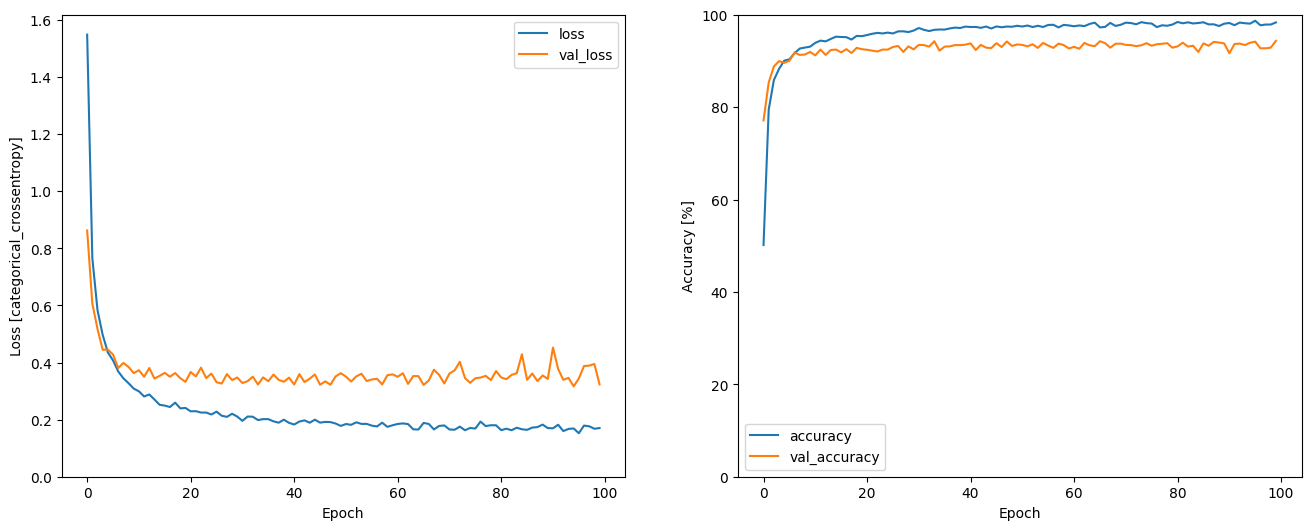

In [11]:
import matplotlib.pyplot as plt

metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [categorical_crossentropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

print('Done!')    

## Evaluate the model performance

In [12]:
# Predict Test Data
y_pred = []
for data, label in tqdm(zip(x_test, y_test)):
    data = np.expand_dims(data, axis=0)
    pred = model.predict(data)
    y_pred.append(np.argmax(pred))

y_true = y_test

# Calculate Evaluation Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

conf_matrix = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)
print('Accuracy: %.3f' % accuracy)
print('F1_score: %.3f' % f1)

print('Done!')    

0it [00:00, ?it/s]

1/1 [==============================] - 0s 243ms/step


1it [00:00,  3.50it/s]

1/1 [==============================] - 0s 19ms/step


3it [00:00,  9.00it/s]

1/1 [==============================] - 0s 21ms/step


5it [00:00,  8.71it/s]

1/1 [==============================] - 0s 19ms/step


7it [00:00, 11.43it/s]

1/1 [==============================] - 0s 18ms/step


10it [00:00, 14.52it/s]

1/1 [==============================] - 0s 21ms/step


12it [00:00, 15.40it/s]

1/1 [==============================] - 0s 20ms/step


14it [00:01, 16.02it/s]

1/1 [==============================] - 0s 18ms/step


16it [00:01, 16.99it/s]

1/1 [==============================] - 0s 18ms/step


19it [00:01, 18.34it/s]

1/1 [==============================] - 0s 61ms/step


21it [00:01, 16.38it/s]

1/1 [==============================] - 0s 23ms/step


23it [00:01, 14.88it/s]

1/1 [==============================] - 0s 24ms/step


25it [00:01, 15.54it/s]

1/1 [==============================] - 0s 20ms/step


27it [00:01, 16.20it/s]

1/1 [==============================] - 0s 20ms/step


29it [00:01, 16.95it/s]

1/1 [==============================] - 0s 21ms/step


31it [00:02, 17.15it/s]

1/1 [==============================] - 0s 20ms/step


33it [00:02, 17.67it/s]

1/1 [==============================] - 0s 20ms/step


35it [00:02, 18.08it/s]

1/1 [==============================] - 0s 19ms/step


37it [00:02, 18.41it/s]

1/1 [==============================] - 0s 20ms/step


40it [00:02, 18.73it/s]

1/1 [==============================] - 0s 20ms/step


42it [00:02, 18.00it/s]

1/1 [==============================] - 0s 20ms/step


44it [00:02, 18.23it/s]

1/1 [==============================] - 0s 20ms/step


46it [00:02, 18.62it/s]

1/1 [==============================] - 0s 19ms/step


48it [00:03, 18.77it/s]

1/1 [==============================] - 0s 20ms/step


50it [00:03, 18.69it/s]

1/1 [==============================] - 0s 19ms/step


52it [00:03, 18.96it/s]

1/1 [==============================] - 0s 20ms/step


54it [00:03, 19.17it/s]

1/1 [==============================] - 0s 21ms/step


56it [00:03, 18.74it/s]

1/1 [==============================] - 0s 22ms/step


58it [00:03, 18.49it/s]

1/1 [==============================] - 0s 20ms/step


60it [00:03, 18.79it/s]

1/1 [==============================] - 0s 20ms/step


62it [00:03, 19.09it/s]

1/1 [==============================] - 0s 20ms/step


64it [00:03, 19.06it/s]

1/1 [==============================] - 0s 21ms/step


66it [00:03, 19.11it/s]

1/1 [==============================] - 0s 19ms/step


68it [00:04, 19.05it/s]

1/1 [==============================] - 0s 20ms/step


71it [00:04, 19.48it/s]

1/1 [==============================] - 0s 19ms/step


74it [00:04, 19.74it/s]

1/1 [==============================] - 0s 19ms/step


76it [00:04, 19.67it/s]

1/1 [==============================] - 0s 21ms/step


79it [00:04, 19.79it/s]

1/1 [==============================] - 0s 19ms/step


82it [00:04, 20.01it/s]

1/1 [==============================] - 0s 20ms/step


85it [00:04, 19.79it/s]

1/1 [==============================] - 0s 23ms/step


87it [00:05, 19.73it/s]

1/1 [==============================] - 0s 19ms/step


90it [00:05, 19.97it/s]

1/1 [==============================] - 0s 20ms/step


92it [00:05, 19.83it/s]

1/1 [==============================] - 0s 20ms/step


94it [00:05, 19.49it/s]

1/1 [==============================] - 0s 20ms/step


96it [00:05, 19.55it/s]

1/1 [==============================] - 0s 19ms/step


99it [00:05, 19.81it/s]

1/1 [==============================] - 0s 19ms/step


102it [00:05, 20.14it/s]

1/1 [==============================] - 0s 19ms/step


105it [00:05, 19.68it/s]

1/1 [==============================] - 0s 23ms/step


107it [00:06, 19.66it/s]

1/1 [==============================] - 0s 19ms/step


109it [00:06, 19.48it/s]

1/1 [==============================] - 0s 21ms/step


112it [00:06, 19.36it/s]

1/1 [==============================] - 0s 19ms/step


114it [00:06, 19.50it/s]

1/1 [==============================] - 0s 19ms/step


116it [00:06, 19.60it/s]

1/1 [==============================] - 0s 19ms/step


119it [00:06, 20.01it/s]

1/1 [==============================] - 0s 20ms/step


121it [00:06, 19.80it/s]

1/1 [==============================] - 0s 19ms/step


123it [00:06, 19.76it/s]

1/1 [==============================] - 0s 18ms/step


126it [00:06, 20.21it/s]

1/1 [==============================] - 0s 18ms/step


129it [00:07, 20.57it/s]

1/1 [==============================] - 0s 19ms/step


132it [00:07, 20.17it/s]

1/1 [==============================] - 0s 29ms/step


135it [00:07, 20.06it/s]

1/1 [==============================] - 0s 19ms/step


138it [00:07, 20.09it/s]

1/1 [==============================] - 0s 19ms/step


141it [00:07, 19.85it/s]

1/1 [==============================] - 0s 24ms/step


143it [00:07, 19.80it/s]

1/1 [==============================] - 0s 19ms/step


146it [00:07, 20.07it/s]

1/1 [==============================] - 0s 20ms/step


149it [00:08, 19.96it/s]

1/1 [==============================] - 0s 19ms/step


152it [00:08, 20.26it/s]

1/1 [==============================] - 0s 19ms/step


155it [00:08, 20.40it/s]

1/1 [==============================] - 0s 20ms/step


158it [00:08, 19.98it/s]

1/1 [==============================] - 0s 18ms/step


161it [00:08, 20.12it/s]

1/1 [==============================] - 0s 18ms/step


164it [00:08, 20.37it/s]

1/1 [==============================] - 0s 19ms/step


167it [00:09, 20.12it/s]

1/1 [==============================] - 0s 19ms/step


170it [00:09, 20.31it/s]

1/1 [==============================] - 0s 19ms/step


173it [00:09, 20.33it/s]

1/1 [==============================] - 0s 18ms/step


176it [00:09, 20.16it/s]

1/1 [==============================] - 0s 18ms/step


179it [00:09, 20.36it/s]

1/1 [==============================] - 0s 19ms/step


182it [00:09, 20.64it/s]

1/1 [==============================] - 0s 19ms/step


185it [00:09, 20.29it/s]

1/1 [==============================] - 0s 19ms/step


188it [00:10, 20.43it/s]

1/1 [==============================] - 0s 18ms/step


191it [00:10, 20.67it/s]

1/1 [==============================] - 0s 20ms/step


194it [00:10, 19.15it/s]

1/1 [==============================] - 0s 19ms/step


196it [00:10, 19.19it/s]

1/1 [==============================] - 0s 20ms/step


198it [00:10, 19.36it/s]

1/1 [==============================] - 0s 20ms/step


200it [00:10, 19.40it/s]

1/1 [==============================] - 0s 19ms/step


202it [00:10, 19.25it/s]

1/1 [==============================] - 0s 22ms/step


204it [00:10, 19.35it/s]

1/1 [==============================] - 0s 19ms/step


207it [00:11, 19.72it/s]

1/1 [==============================] - 0s 20ms/step


209it [00:11, 19.37it/s]

1/1 [==============================] - 0s 21ms/step


211it [00:11, 19.14it/s]

1/1 [==============================] - 0s 20ms/step


213it [00:11, 19.22it/s]

1/1 [==============================] - 0s 43ms/step


215it [00:11, 17.91it/s]

1/1 [==============================] - 0s 24ms/step


217it [00:11, 14.91it/s]

1/1 [==============================] - 0s 22ms/step


219it [00:11, 15.58it/s]

1/1 [==============================] - 0s 23ms/step


221it [00:11, 15.63it/s]

1/1 [==============================] - 0s 21ms/step


223it [00:12, 16.25it/s]

1/1 [==============================] - 0s 22ms/step


225it [00:12, 16.79it/s]

1/1 [==============================] - 0s 20ms/step


227it [00:12, 17.55it/s]

1/1 [==============================] - 0s 22ms/step


229it [00:12, 17.56it/s]

1/1 [==============================] - 0s 20ms/step


231it [00:12, 18.05it/s]

1/1 [==============================] - 0s 20ms/step


234it [00:12, 18.84it/s]

1/1 [==============================] - 0s 20ms/step


237it [00:12, 19.33it/s]

1/1 [==============================] - 0s 19ms/step


239it [00:12, 19.21it/s]

1/1 [==============================] - 0s 19ms/step


240it [00:12, 18.59it/s]

Precision: 0.962
Recall: 0.958
Accuracy: 0.958
F1_score: 0.959
Done!


## Display a confusion matrix

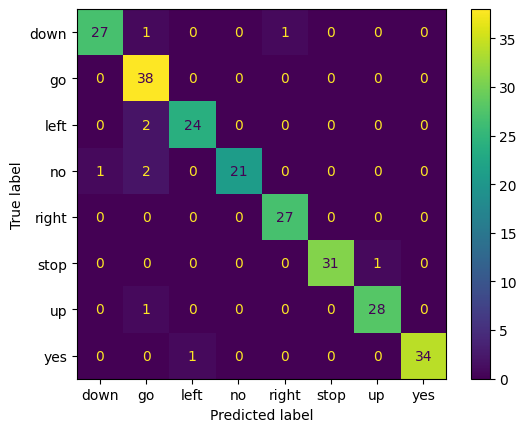

Done!


<Figure size 640x480 with 0 Axes>

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = keyword_list)
cm_display.plot()
plt.show()

# Save confusion matrix image
confusion_matrix_image = osp.join(PATH, 'reports/confusion_matrix.png')
plt.savefig(confusion_matrix_image)

print('Done!')    

## Save metrics

In [14]:
import json

metrics_file = osp.join(PATH, 'reports/metrics.json')

metrics = {
    'Precision': precision,
    'Recall':recall,
    'Accuracy': accuracy,
    'F1_score':f1
}

with open(metrics_file, 'w', encoding ='utf8') as json_file:
    json.dump(metrics, json_file, indent=4)

print('Done!')    

Done!
